In [107]:
%load_ext autoreload
%autoreload 2

In [108]:
import os
from datetime import datetime
from sentinelhub import (
    SHConfig, 
    DataCollection, 
    SentinelHubRequest, 
    MimeType,
    CRS,
    BBox,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    bbox_to_dimensions,
    WmsRequest
)

from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

import sys
sys.path.append("../utils")
import utils

import numpy as np

In [27]:
# Configure Sentinel Hub instance
config = SHConfig()
config.sh_client_id = os.environ.get('SH_CLIENT_ID')
config.sh_client_secret = os.environ.get('SH_CLIENT_SECRET')

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [159]:
# Define bounding box for the Belgian Ardennes
bbox_ardennes_wgs84 = (5.467896,50.424603,6.044678,50.654956)

# Set resolution and bbox
resolution = 20
ardennes_bbox = BBox(bbox=bbox_ardennes_wgs84, crs=CRS.WGS84)
ardennes_size = bbox_to_dimensions(ardennes_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {ardennes_size} pixels")

# Define time interval for summer of 2022 (June to August)
time_interval = ('2022-06-15', '2022-08-15')

# Define data collections
data_collections = [
    DataCollection.SENTINEL1_IW,
    DataCollection.SENTINEL2_L2A
]

# Save images into a data folder and make sure to gitignore the folder
# Download and save Sentinel-1 data
output_folder_s1 = r"../../data/input_imagery/sentinel1/"
output_folder_s2 = r"../../data/input_imagery/sentinel2/"


Image shape at 20 m resolution: (1996, 1356) pixels


In [160]:
evalscript_all_bands_s2 = """
//VERSION=3
function setup() {
    return {
        input: [{
            bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"],
            units: "DN"
        }],
        output: {
            bands: 12,
            sampleType: "INT16"
        }
    };
}

function evaluatePixel(sample) {
    return [sample.B01,
            sample.B02,
            sample.B03,
            sample.B04,
            sample.B05,
            sample.B06,
            sample.B07,
            sample.B08,
            sample.B8A,
            sample.B09,
            sample.B11,
            sample.B12];
}
"""

request_all_bands_s2 = SentinelHubRequest(
    data_folder=output_folder_s2,
    evalscript=evalscript_all_bands_s2,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection= DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=ardennes_bbox,
    size=ardennes_size,
    config=config,
    )

In [161]:
# Query, load and save data
sentinel2 = request_all_bands_s2.get_data(save_data=True)

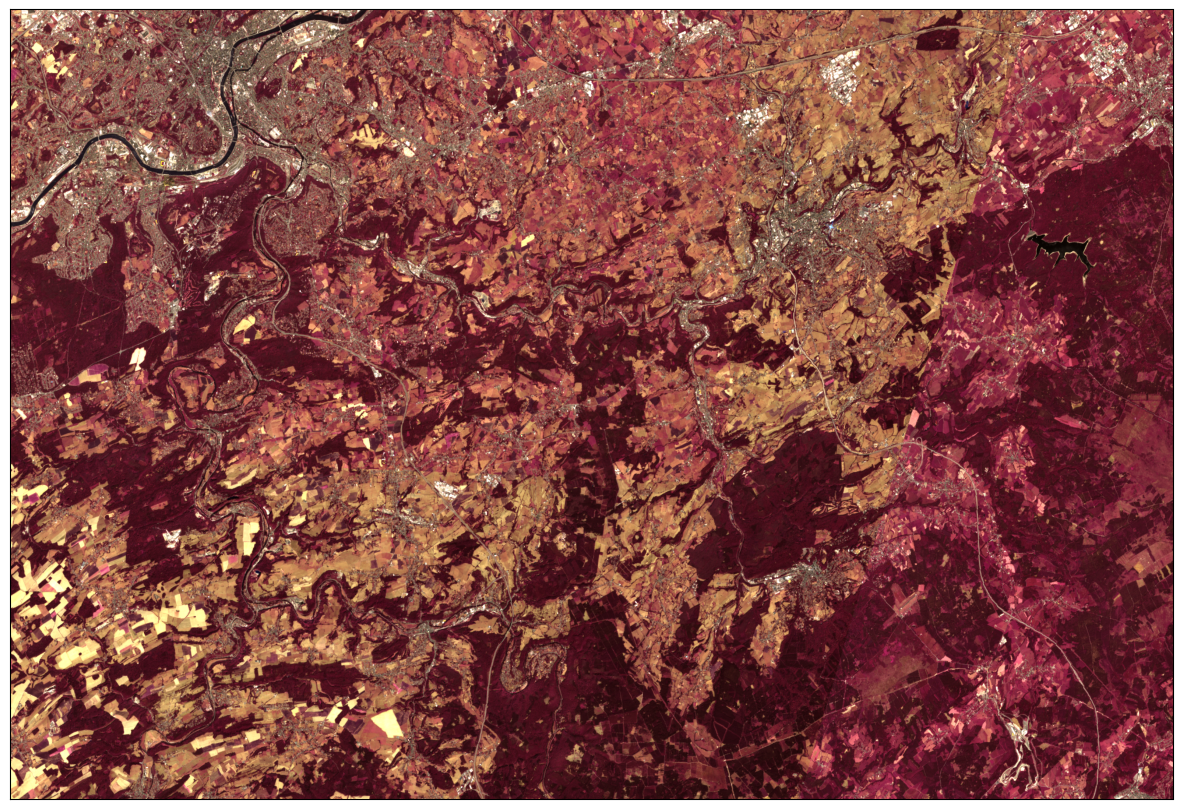

In [138]:
# Visualize data
min_values, max_values = utils.get_stats_from_img(sentinel2[0])
scaled_image = utils.min_max_scaling(sentinel2[0], min_values, max_values)
utils.plot_image(scaled_image[:,:,[4,3,2]], factor=8, clip_range=(0, 1))

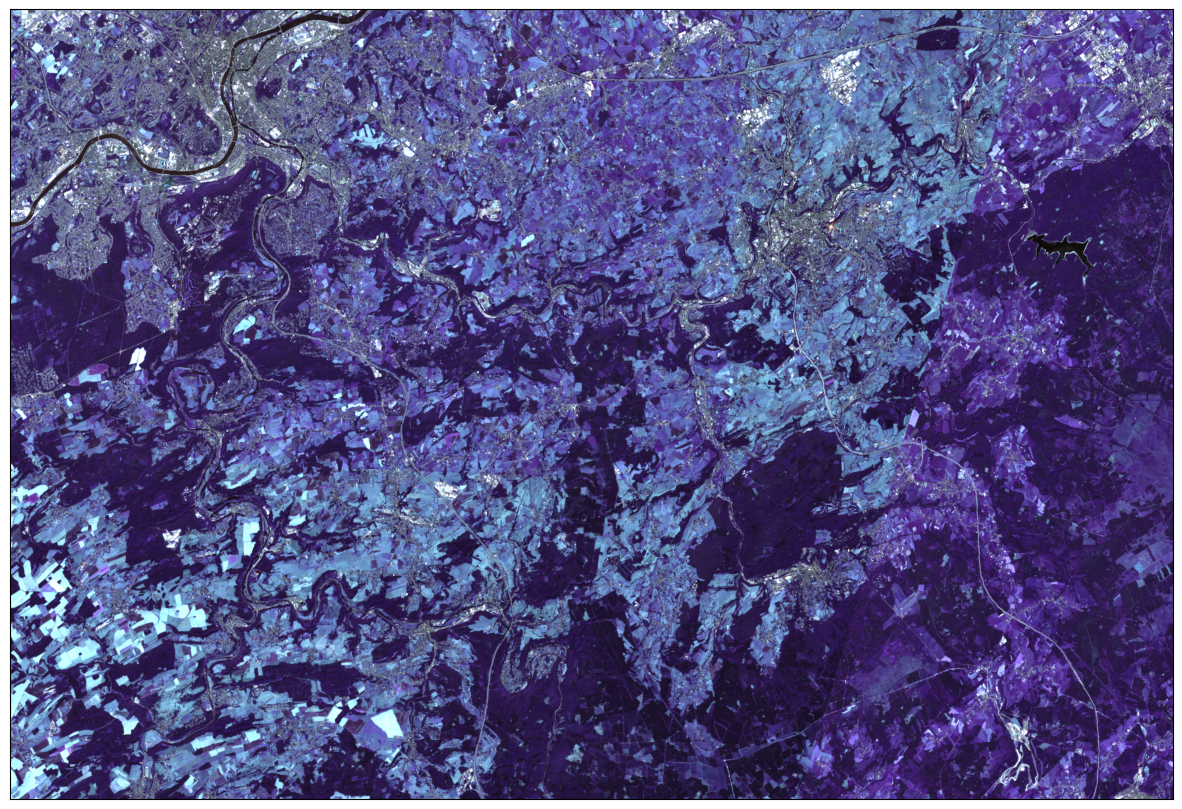

In [139]:
# From raw bands we can also construct a False-Color image
# False color image is (B03, B04, B08)
#utils.plot_image(sentinel2[0][:, :, [2, 3, 7]], factor=3.5 / 1e4, clip_range=(0, 1))

# False color image is (B03, B04, B08)

utils.plot_image(sentinel2[0][:, :, [2, 3, 4]], factor=0.0005, clip_range=(0, 1))

In [166]:
s1_with_datamask_evalscript = """
//VERSION=3

function evaluatePixel(sample) {
    return [sample.VV, 2 * sample.VH, sample.VV / sample.VH / 100.0, sample.dataMask]
}

function setup() {
  return {
    input: [{
      bands: [
        "VV",
        "VH",
        "dataMask"
      ]
    }],
    output: {
      bands: 4,
      sampleType:"FLOAT32"
    }
  }
}
"""
# Create the Sentinel-1 IW request with data collection SENTINEL1_IW
s1_iw_request_datamask = SentinelHubRequest(
  data_folder=output_folder_s1,
  evalscript=s1_with_datamask_evalscript,
     input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW,
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.MOST_RECENT
        )
    ],
  responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
  bbox=ardennes_bbox,
  size=ardennes_size,  # Adjust size as needed
  config=config
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


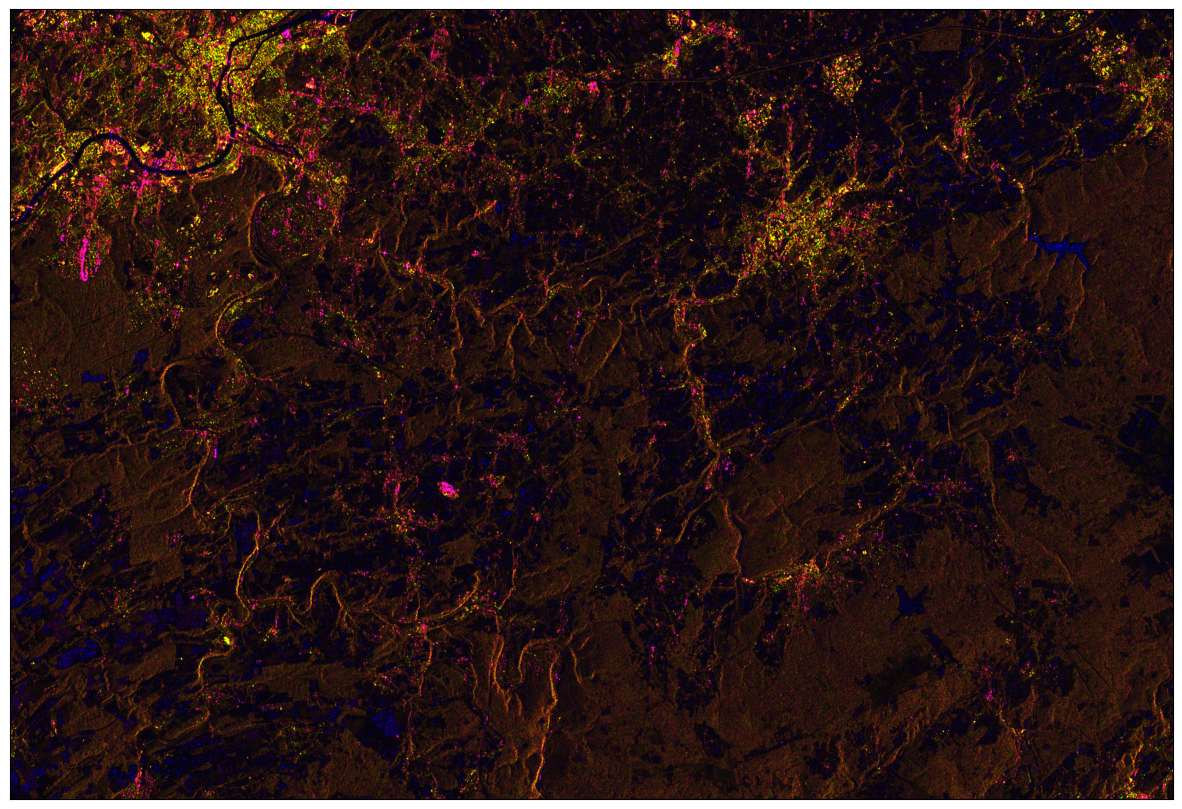

In [167]:
%%time
# Retrieve and plot the Sentinel-1 IW data
# Can take some time before files are visible in explorer
sentinel1 = s1_iw_request_datamask.get_data(save_data=True)
utils.plot_image(sentinel1[-1])
#plot_image(s1_iw_request_datamask_data[-1][:, :, -1])

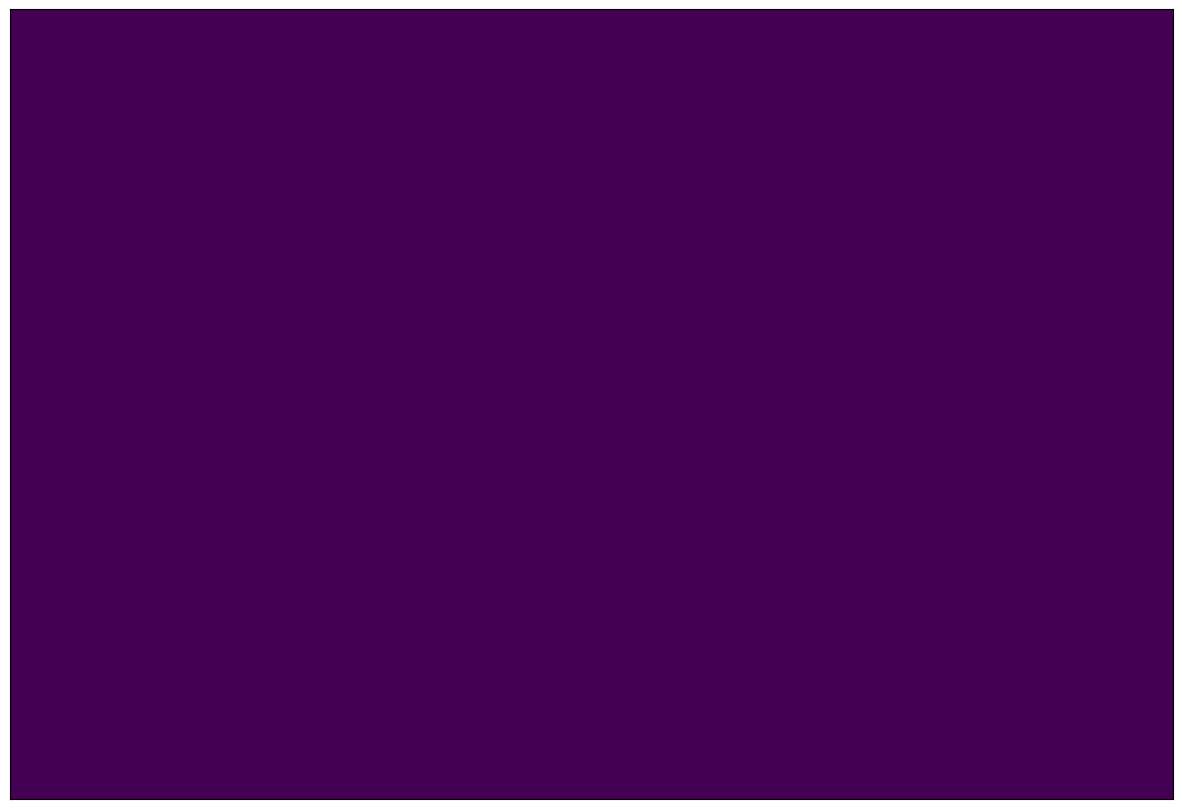

In [143]:
utils.plot_image(sentinel1[-1][:, :, -1])

TypeError: save_data() takes 1 positional argument but 2 were given

In [149]:
help(request_all_bands_s2.save_data)

Help on method save_data in module sentinelhub.base:

save_data(*, data_filter: Optional[List[int]] = None, redownload: bool = False, max_threads: Optional[int] = None, raise_download_errors: bool = False, show_progress: bool = False) -> None method of sentinelhub.api.process.SentinelHubRequest instance
    Saves data to disk. If ``redownload=True`` then the data is redownloaded using ``max_threads`` workers.
    
    :param data_filter: Used to specify which items will be returned by the method and in which order. E.g. with
        `data_filter=[0, 2, -1]` the method will return only 1st, 3rd and last item. Default filter is `None`.
    :param redownload: data is redownloaded if ``redownload=True``. Default is `False`
    :param max_threads: Maximum number of threads to be used for download in parallel. The default is
        `max_threads=None` which will use the number of processors on the system multiplied by 5.
    :param raise_download_errors: If `True` any error in download proce